In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.signal import welch

In [2]:
c = 3.0*1e8  # (m/s)
density = 1850  # kg/m³ (SiO2)
kB = 1.380649e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
R = 75e-9  # particle radius (m)
T = 297 # K
lamb = 1064*1e-9  # (m)
NA = 0.77
P = 250*1e-3 # Total Power (W), and here I'm considering that the two beams are of same power, half of P actually
m_gas = 4.81e-26 # molecular mass of air
Pressure_atm = 1013.25 #mbar (=1 atm)
Pressure = (Pressure_atm)/101.325
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2

In [3]:
k = 2*np.pi/lamb
w_0 = lamb/(np.pi*NA) # incident beam waist (m)
m_rri = n_p/n_md #relative refractive index
z_R = (np.pi * w_0**2) / lamb #rayleigh range #checar isso aqui!!!!!!!!!!!!!!!
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg

In [4]:
def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

def R_curv(z):
    z_safe = np.where(z == 0, 1e-40, z)       #Isso aqui impede que o código quebre em z = 0 substituindo esse
    return z_safe*(1+((z_R**2)/(z_safe**2)))  #ponto por um outro valor muito pequeno diferente de zero.

def gouy_phase(z):
    return np.arctan(z/z_R)

def w(z):
    return w_0*((1+((z**2)/(z_R**2)))**(1/2))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

In [5]:
N = 10_000_000
dt = 1e-9
t = np.linspace(0,dt*N,N)
gamma_hz = Gamma_env(Pressure)
x = np.linspace(-30*w_0,30*w_0,len(t))
y = np.linspace(-30*w_0,30*w_0,len(t))
z = np.linspace(-30*z_R, 30*z_R, len(t))

In [6]:
def E(x,y,z):
    E_0 = (np.sqrt(P/(np.pi*(w_0**2)*c*epsilon_0)))
    return E_0*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*(z)+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

In [7]:
I_z = I(E(0, 0, z))
I_x = I(E(x, 0, 0))
I_y = I(E(0, y, 0))

F_scatt_z = ((128*(np.pi**5)*(n_md**5)*(R**6))/(3*c*(lamb**4)))*((((m_rri**2)-1)/((m_rri**2)+2))**2)*I_z

F_grad_x = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_x, x)
F_grad_y = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_y, y)
F_grad_z = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_z, z)

F_total_x = F_grad_x
F_total_y = F_grad_y
F_total_z = F_grad_z + F_scatt_z

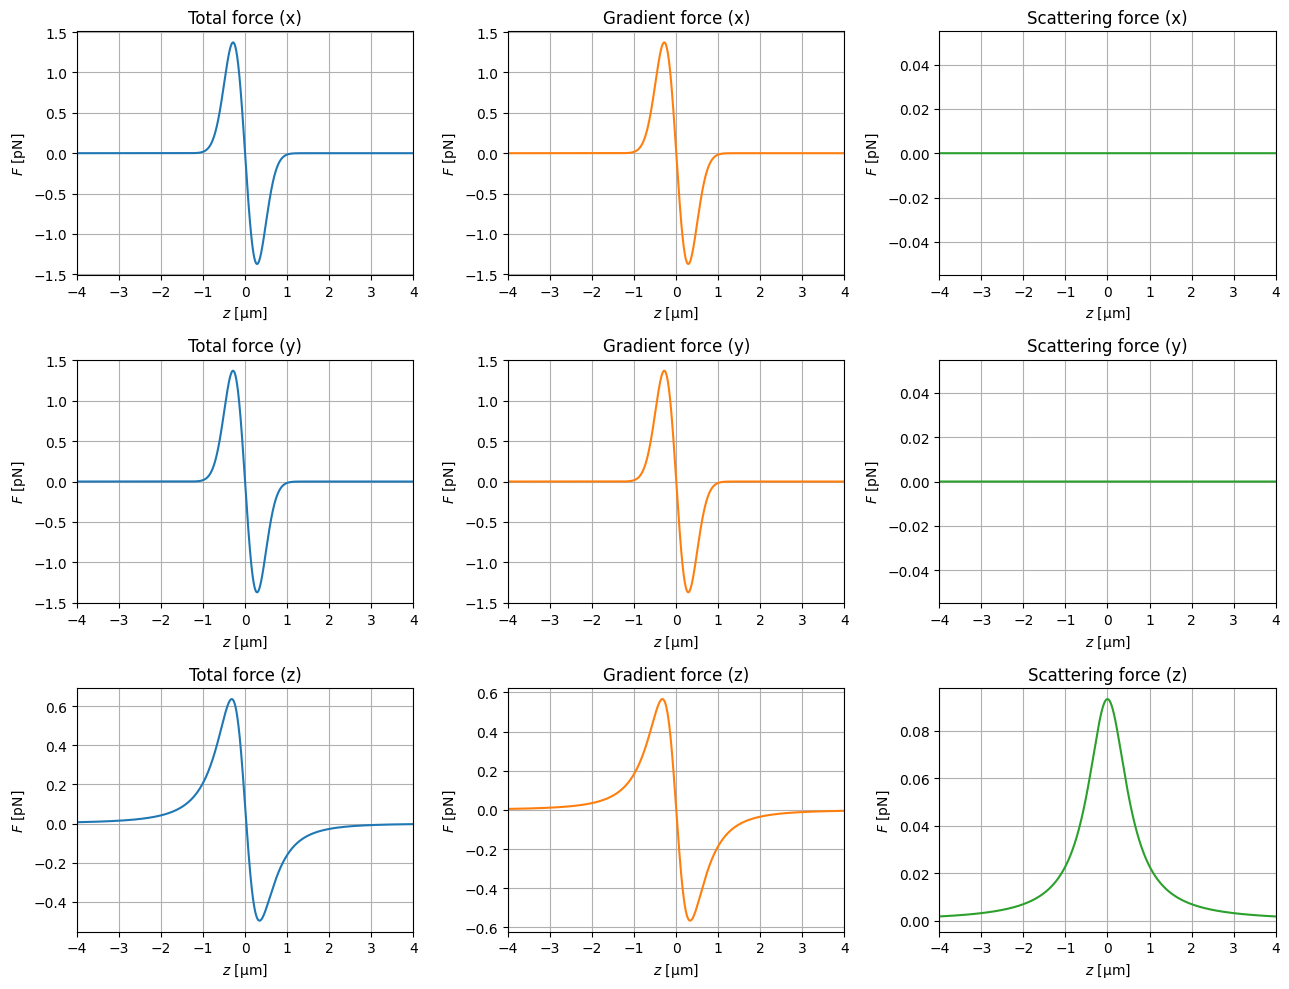

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(13, 10))

forces_x = (F_total_x, F_grad_x, np.zeros_like(F_grad_x))
forces_y = (F_total_y, F_grad_y, np.zeros_like(F_grad_y))
forces_z = (F_total_z, F_grad_z, F_scatt_z)

force_titles = ["Total force", "Gradient force", "Scattering force"]
axis_labels = ['x', 'y', 'z']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (F_x, F_y, F_z) in enumerate([forces_x, forces_y, forces_z]):
    for j, F in enumerate([F_x, F_y, F_z]):
        axs[i, j].plot(z * 1e6, F * 1e12, color=colors[j])
        axs[i, j].set_xlim(-4, 4)
        axs[i, j].set_xlabel(r'$z\ \left[\mathrm{\mu m}\right]$')
        axs[i, j].set_ylabel(r'$F\ \left[\mathrm{pN}\right]$')
        axs[i, j].set_title(f"{force_titles[j]} ({axis_labels[i]})")
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(pos,F_total,v):
    return F_total/m - gamma_hz*v

In [10]:
@njit(fastmath=True)
def runge_kutta(v_init, pos_init):
    positions = np.zeros((len(t), 3))
    velocities = np.zeros((len(t), 3))
    
    positions[0, :] = pos_init
    velocities[0, :] = v_init

    for i in range(len(t) - 1):
        Fx = np.interp(positions[i, 0], x, F_total_x)
        Fy = np.interp(positions[i, 1], y, F_total_y)
        Fz = np.interp(positions[i, 2], z, F_total_z)
        Fs = np.array([Fx, Fy, Fz])

        k1_pos = velocities[i] * dt
        k1_v = np.array([dv_dt(positions[i, j], Fs[j], velocities[i, j]) for j in range(3)]) * dt

        k2_pos = (velocities[i] + 0.5 * k1_v) * dt
        k2_v = np.array([dv_dt(positions[i, j] + 0.5 * k1_pos[j], Fs[j], velocities[i, j] + 0.5 * k1_v[j]) for j in range(3)]) * dt

        k3_pos = (velocities[i] + 0.5 * k2_v) * dt
        k3_v = np.array([dv_dt(positions[i, j] + 0.5 * k2_pos[j], Fs[j], velocities[i, j] + 0.5 * k2_v[j]) for j in range(3)]) * dt

        k4_pos = (velocities[i] + k3_v) * dt
        k4_v = np.array([dv_dt(positions[i, j] + k3_pos[j], Fs[j], velocities[i, j] + k3_v[j]) for j in range(3)]) * dt

        positions[i + 1] = positions[i] + (1.0 / 6.0) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
        velocities[i + 1] = velocities[i] + (1.0 / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

        thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal(0, 1, 3) * np.sqrt(dt) / m
        velocities[i + 1] += thermal_noise

    return positions, velocities


In [11]:
x0 = np.array([0.0, 0.0, 0.0]) #(dt)*np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
v0 = np.array([0.0, 0.0, 0.0]) #np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
fs = 1/dt

P = []
V = []
F = []
PSDs = []
num_PSD = 10
for i in range(num_PSD):
    positions,velocities = runge_kutta(v0,x0)
    P.append(positions)
    V.append(velocities)

    f, Pxx = welch(positions[:,0], fs=fs, window='hamming', nperseg=len(positions[:,0]))
    f, Pyy = welch(positions[:,1], fs=fs, window='hamming', nperseg=len(positions[:,1]))
    f, Pzz = welch(positions[:,2], fs=fs, window='hamming', nperseg=len(positions[:,2]))
    
    F.append(f)
    PSDs.append([Pxx,Pyy,Pzz])

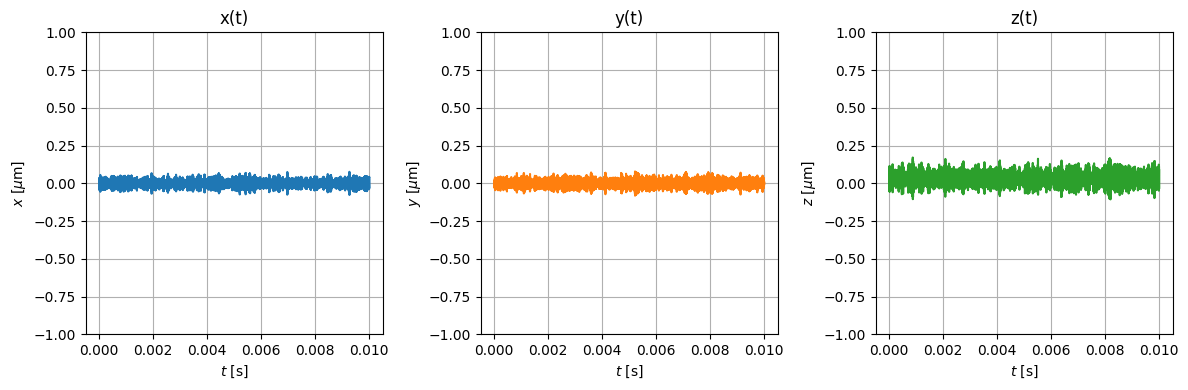

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

l = 0

axs[0].plot(t, P[l][:,0] * 1e6, color='#1f77b4')
axs[0].set_ylim(-1, 1)
axs[0].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[0].set_ylabel(r'$x\ \left[\mu\mathrm{m}\right]$')
axs[0].set_title("x(t)")
axs[0].grid(True)

axs[1].plot(t, P[l][:,1] * 1e6, color='#ff7f0e')
axs[1].set_ylim(-1, 1)
axs[1].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[1].set_ylabel(r'$y\ \left[\mu\mathrm{m}\right]$')
axs[1].set_title("y(t)")
axs[1].grid(True)

axs[2].plot(t, P[l][:,2] * 1e6, color='#2ca02c')
axs[2].set_ylim(-1, 1)
axs[2].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[2].set_ylabel(r'$z\ \left[\mu\mathrm{m}\right]$')
axs[2].set_title("z(t)")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [13]:
mean_PSD = [np.zeros_like(PSDs[0][0]), np.zeros_like(PSDs[0][1]), np.zeros_like(PSDs[0][2])]

for j in range(num_PSD):
    for i in range(3):
        mean_PSD[i] += PSDs[j][i]

for i in range(3):
    mean_PSD[i] /= num_PSD

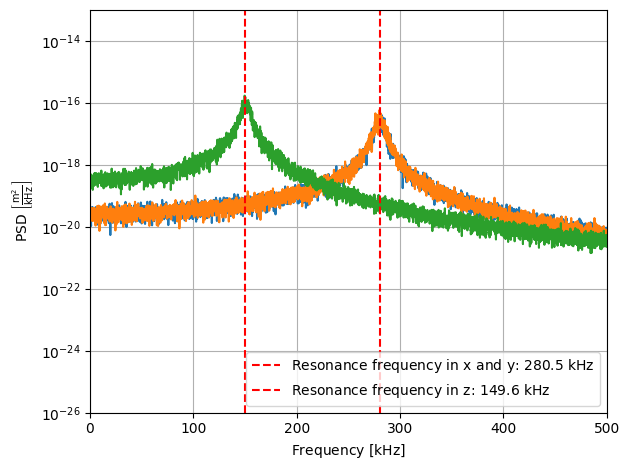

In [14]:
idx_max_x = np.argmax(mean_PSD[0][250:]) + 250  # +1 porque estamos usando Pxx[1:], arrancando o primeiro ponto por conta do erro gerado por ser igual a zero
idx_max_y = np.argmax(mean_PSD[1][250:]) + 250
idx_max_z = np.argmax(mean_PSD[2][250:]) + 250
f_max = [f[idx_max_x],f[idx_max_y],f[idx_max_z]]

plt.plot(f[1:]/1e3,mean_PSD[0][1:]*1e3)
plt.plot(f[1:]/1e3,mean_PSD[1][1:]*1e3)
plt.plot(f[1:]/1e3,mean_PSD[2][1:]*1e3)
plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e-26,1e-13)
plt.xlim(0,0.5e6/1e3)
plt.xlabel(r'Frequency $\left[\mathrm{kHz}\right]$')
plt.ylabel(r'PSD $\left[\frac{\mathrm{m}^2}{\mathrm{kHz}}\right]$')
plt.axvline(f_max[0]/1e3, color='r', linestyle='--',label=fr'Resonance frequency in x and y: {f_max[0]/1e3:.1f} $\mathrm{{kHz}}$')
#plt.axvline(f_max[1]/1e3, color='r', linestyle='--',label=fr'Resonance frequency in y: {f_max[1]/1e3:.1f} $\mathrm{{kHz}}$')
plt.axvline(f_max[2]/1e3, color='r', linestyle='--',label=fr'Resonance frequency in z: {f_max[2]/1e3:.1f} $\mathrm{{kHz}}$')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
var_x = []
var_y = []
var_z = []

for positions in P:
    var_x.append(np.var(positions[:, 0]))
    var_y.append(np.var(positions[:, 1]))
    var_z.append(np.var(positions[:, 2]))

mean_var_x = np.mean(var_x)
mean_var_y = np.mean(var_y)
mean_var_z = np.mean(var_z)

In [16]:
k_spring=m*(2*np.pi*f_max[2])**2
freq = np.sqrt(k_spring/m)
var_X = (kB*T/(m*freq**2))

print(mean_var_z,var_X)
print(mean_var_z/var_X)

#esse teste melhora se tirarmos a força de scattering.

1.3799399457044138e-15 1.419621867013545e-15
0.9720475415100431
